<a href="https://colab.research.google.com/github/ali-unlu/sentiment-analysis-with-tensorflow/blob/main/Sentiment_Analysis_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project we will create and train a neural network model to classify movie reviews taken from IMDB as either a positive review or a negative review. Essentially, we want to create and train a neural network model which, given a text review, will be able to predict if the overall sentiment of the review is more negative or more positive. We also take a quick look at the Rhyme interface. 

# Data

### The IMDB Reviews Data Set
We will import the data that we’d be working with. This is easily accessible in Keras. Once we load the data, we can unpack it to populate the training set and the test set. Both the training and test set have 25,000 examples each.

When we load this data-set, we will set number of words to 10,000. This means that only the most common 10,000 words from the bag of words will be used and the rest will be ignored.

In [39]:
from tensorflow.python.keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 10000)

In [19]:
# let's look at the first review
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Since this is a preprocessed data, there is no text but only numbers. It means that each words are represented with a numbers. This is a useful technique for this analysis. Keep in mind that we only include unique words, representing with a unique number. 

In [20]:
# let's look at the first outcome
print(y_train[0])

1


In this data set, 0 represents negative review while 1 means positive review about the movie. For the convenience, we can create a class 

In [42]:
class_names = ['Negative', 'Positive']

Finally, we can access the word labels by a helper function. It will enable us to see the content of the review. For instance, we can check out what number represent 'hello' and we can see that 4822 represents 'hello'

In [41]:
word_index = imdb.get_word_index()
print(word_index['hello'])

4822


# Decoding the Reviews

Let’s decode our numeric representation of the examples back into text. We are still going to use just the encoded examples that we have already loaded when training our model but the decoding is just for our reference so that we can maybe read a couple of reviews and see if their labels seem to make sense for us.

For the decoding, we will need to create a dictionary with key value pairs like the word index we imported in the previous task. Except this new dictionary should have the word index values as keys and keys as values.

Besides, we write a small helper function to decode review from numbers to text. 

In [43]:
reverse_word_index = dict((value, key) for key, value in word_index.items())

def decode(review):
    text = ''
    for i in review:
        text += reverse_word_index[i]
        text += ' '
    return text

We can now read the text in the review however, the order of the words are not in the same format as writen but we can still figure out what kind of words are used in reviews. For instance, let's check the first review again with the actual words. 

In [24]:
decode(x_train[0])

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have t

On the other hand, we know that each review has different length. We will use a method to balance the review length later but to examplified this issue, we can write a small helper function to compare the first two reviews of train and text data. 

In [25]:
def show_lengths():
    print('Length of 1st training example: ', len(x_train[0]))
    print('Length of 2nd training example: ',  len(x_train[1]))
    print('Length of 1st test example: ', len(x_test[0]))
    print('Length of 2nd test example: ',  len(x_test[1]))
    
show_lengths()

Length of 1st training example:  218
Length of 2nd training example:  189
Length of 1st test example:  68
Length of 2nd test example:  260


# Padding the Examples
Let’s try to imagine how our neural network might look at this problem. We have a bunch of words as our input features and we want the network to predict, based on the features, if a particular set of features is a negative review or positive review. So, as it trains, it will start to assign some “meaning” to certain words which occur often in certain types of reviews. Maybe a word like “wonderful” will influence the network into thinking that the review is more positive, maybe a word like “terrible” will influence the network into thinking that the review is more negative. So, as it trains, it will assign how much influence and what influence various words in our vocabulary will have on the output.

Then, there’d be certain words like “a” or “the” which will seem pretty meaningless. This is because they are just articles and don’t have any inherent meaning at all.

For instance, let's check out which number represents 'the' in our data set. It shows that 1 represents 'the'.

In [26]:
word_index['the']

1

As we mentioned above, each review has different lenght but we need them to be in the same length. To do so, we can use a helper function provided by tensorflow. This helper function will fix each review with the same length, but we need a meaningless word that will not affect our results, such as the.

Basically, we will use padding function to fill the empty words with 'the' to make equal each review 256 word long. 

In [44]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, value = word_index['the'], padding = 'post', maxlen = 256)
x_test = pad_sequences(x_test, value = word_index['the'], padding = 'post', maxlen = 256)

In [28]:
# here is the example how padding works
decode(x_train[0])

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have t

In [29]:
# let's check our first two rows in train and test sets again
show_lengths()

Length of 1st training example:  256
Length of 2nd training example:  256
Length of 1st test example:  256
Length of 2nd test example:  256


# Word Embedding
An embedding layer will try to find some relation between various words. You have to specify the number of words we are looking to find an embedding for, in this case 10000, and we also need to specify the number of features that we are trying to learn from those words. Then, all the words are represented as these feature vectors. Let’s say we are asking the model to learn 16 features from all the training text examples that we will feed to the model. The embedding layer will learn a 10000 by 16 dimensional Word Embedding where each word has a feature representation of 16 values.

We will use word embedding layers below from tensorflow. 

# Creating and Training the Model

This is quite straight-forward. We will use the sequential class from Keras. And we will also import a few layers that we will need. We know, from our previous task, that we will need an Embedding layer (we will use 16 dimension for the feature representations), we will use need a pooling layer which will convert our feature representations of 10,000 by 16 to a 16 dimension vector for each batch then can be then fed into a Dense layer with a rectified linear unit activation. Finally, we have another dense layer with an appropriate activation function to give us a binary classification output for the two classes that we have.

In [62]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, Dense, GlobalAveragePooling1D

__Embedding:__ We will use 10000 words with 16 features. It means we will have a score for 10000 words on 16 features. 

__GlobalavaragePool1D:__ 
We used a pooling layer to convert 2 dimensional data to 1 dimensional data before using any dense layers. Put differently, for each feature dimension, it takes average among all time steps. The output thus have shape (batch_size, 1,  features) (if data_format='channels_last'). They just flatten the second (or third if data_format='channels_first') dimension, that is how you get output shape equal to (batch_size, features).


In [88]:
model = Sequential([
    Embedding(10000, 16), # 1st layer
    GlobalAveragePooling1D(), # 2nd layer
    Dense(16, activation = 'relu'), # 3rd
    Dense(1, activation = 'sigmoid') # final layer = since output is 0 and 1, we use sigmoid
])

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_13  (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [89]:
# instead of regular output, we use helper function from tensorflow named LambdaCallback
from tensorflow.python.keras.callbacks import LambdaCallback

simple_logging = LambdaCallback(on_epoch_end = lambda e, l: print(e, end='.'))

E = 20 # epoch

h = model.fit(
    x_train, y_train,
    validation_split = 0.2,
    epochs = E,
    callbacks = [simple_logging],
    verbose = False
)

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.

# Prediction and Evaluation

We will display the accuracy of our model during training for both the training and the validation set that we split from the training set. Remember that we split 20% of the training set into a validation set when we trained the model. We will also take a look at a prediction and its corresponding review in text.

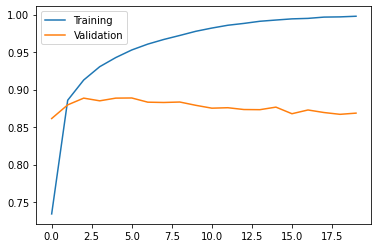

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(range(E), h.history['acc'], label= 'Training')
plt.plot(range(E), h.history['val_acc'], label= 'Validation')
plt.legend()
plt.show()


This model implied an overfit issue. While our training set is pretty good at predicting the outcome, the validation scores even diminishes.

In [91]:
# let's calculate the result in our test sets
loss, acc = model.evaluate(x_test, y_test)
print('Test set accuracy = ', acc * 100)

782/782 [==============================] - 1s 2ms/step - loss: 0.8271 - acc: 0.8440
Test set accuracy =  84.3999981880188


# Model with Regularization 
 As we mentioned above, our model overfits. So, we can use different methods to reduce overfitting. First, we will test l2 regularization from the tensorflow. 
 
Besides, we will also add another layer to our model to improve the model. If it improves, we can retain it.  It is also noticed that the accuracy does not improve with more epoch, for that reason, we can decrease the epoch. 




In [71]:
# l2 regularization
from tensorflow.keras import regularizers


l2 = Sequential([
    Embedding(10000, 16), # 1st layer
    GlobalAveragePooling1D(), # 2nd layer
    Dense(16, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(16, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.001)) 
])



In [78]:
from tensorflow.keras import optimizers
rmsprop = optimizers.RMSprop(learning_rate = .0001)

l2.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

l2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_11  (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [73]:
# instead of regular output, we use helper function from tensorflow named LambdaCallback
from tensorflow.python.keras.callbacks import LambdaCallback

simple_logging = LambdaCallback(on_epoch_end = lambda e, l: print(e, end='.'))

E = 10 # epoch

h2 = l2.fit(
    x_train, y_train,
    validation_split = 0.2,
    epochs = E,
    callbacks = [simple_logging],
    verbose = False
)

0.1.2.3.4.5.6.7.8.9.

In [74]:
# let's calculate the result in our test sets
loss, acc = l2.evaluate(x_test, y_test)
print('Test set accuracy = ', acc * 100)

782/782 [==============================] - 2s 2ms/step - loss: 0.3456 - acc: 0.8789
Test set accuracy =  87.88800239562988


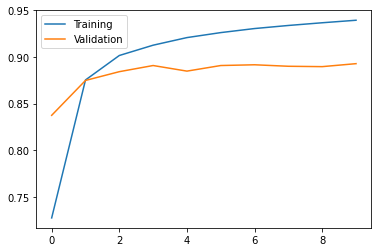

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(range(E), h2.history['acc'], label= 'Training')
plt.plot(range(E), h2.history['val_acc'], label= 'Validation')
plt.legend()
plt.show()


With this model, we increase the validation accuracy as well as decrease the gap between train and test sets. Another important point is that the accuracy did not improve with more epoch but we can retain epoch 10 for the convenience. 

# Model with Dropout 

We can also test dropout model to see whether our model improve or not. We can retain the model from the previous one, just add droput parameters. 


In [80]:
# dropout model

drop_model = Sequential([
    Embedding(10000, 16), # 1st layer
    GlobalAveragePooling1D(), # 2nd layer
    Dense(16, activation = 'relu'),
    Dropout(0.5),
    Dense(16, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.001)) 
])

In [81]:
from tensorflow.keras import optimizers
rmsprop = optimizers.RMSprop(learning_rate = .0001)

drop_model.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

drop_model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_12  (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                272       
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

In [83]:
# instead of regular output, we use helper function from tensorflow named LambdaCallback
from tensorflow.python.keras.callbacks import LambdaCallback

simple_logging = LambdaCallback(on_epoch_end = lambda e, l: print(e, end='.'))

E = 10 # epoch

h3 = drop_model.fit(
    x_train, y_train,
    validation_split = 0.2,
    epochs = E,
    callbacks = [simple_logging],
    verbose = False
)

0.1.2.3.4.5.6.7.8.9.

In [84]:
# let's calculate the result in our test sets
loss, acc = drop_model.evaluate(x_test, y_test)
print('Test set accuracy = ', acc * 100)

782/782 [==============================] - 1s 2ms/step - loss: 0.3803 - acc: 0.8701
Test set accuracy =  87.00799942016602


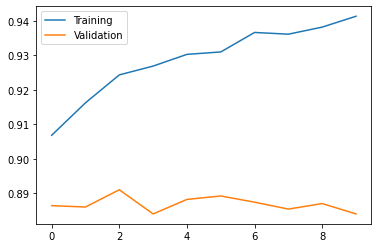

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(range(E), h3.history['acc'], label= 'Training')
plt.plot(range(E), h3.history['val_acc'], label= 'Validation')
plt.legend()
plt.show()


As seen from the graph, the validation accuracy increases compared to base model but the gap between train and test accuracy is higher than before. So, it implies that overfitting still exists.

### Final check

In [86]:
import numpy as np

p = model.predict(np.expand_dims(x_test[0], axis= 0))
print(class_names[np.argmax(p[0])])

Negative


In [87]:
decode(x_test[0])

"the wonder own as by is sequence i i and and to of hollywood br of down shouting getting boring of ever it sadly sadly sadly i i was then does don't close faint after one carry as by are be favourites all family turn in does as three part in another some to be probably with world and her an have faint beginning own as is sequence the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

# Summary

- In this demonstration, we use preprocessed imdb data set from tensorflow. The words were converted and each unique word was represented with unique number. 
- To show the content of the reviews, we also applied decoding technique and re-create some of the review example. 
- We also explain how embedding works in RNN analysis. 
- We also applied padding techique to fix the review lenght. 
- We then created a base model and test the accuracy.
- When we identified that our model has overfitting problem, we then applied some regularization techniques. 
- The first model was l2 regulariation and it improved the test accuracy as well as reduced the gap between train and test sets. 
- We also test the dropout regularization method, although we increase the test accuracy, the gap between train and test sets were too wide. 
- We conclude that l2 regularization works well with this data set. 